In [23]:
df_learn.columns


Index(['Unnamed: 0.1', 'Unnamed: 0', 'gameId', 'finishedAt', 'gameLobbyId',
       'treatmentId', 'roundIds', 'playerIds', 'batchId', 'createdAt',
       'data.justStarted', 'data.gameStartTimestamp', 'data.gameEndTimestamp',
       'data.totalPayoff', 'chat_log', '_id', 'name', 'CONFIG_configId',
       'CONFIG_playerCount', 'CONFIG_numRounds', 'CONFIG_showNRounds',
       'CONFIG_endowment', 'CONFIG_multiplier', 'CONFIG_allOrNothing',
       'CONFIG_chat', 'CONFIG_defaultContribProp', 'CONFIG_punishmentExists',
       'CONFIG_punishmentCost', 'CONFIG_punishmentMagnitude',
       'CONFIG_rewardExists', 'CONFIG_rewardCost', 'CONFIG_rewardMagnitude',
       'CONFIG_showOtherSummaries', 'CONFIG_showPunishmentId',
       'CONFIG_showRewardId', 'CONFIG_contributionDuration',
       'CONFIG_outcomeDuration', 'CONFIG_summaryDuration', 'CONFIG_basePay',
       'CONFIG_conversionRate', 'CONFIG_treatmentName',
       'CONFIG_punishmentTech', 'CONFIG_MPCR', 'CONFIG_scaledPunishmentCost',
       

In [24]:
df_learn['CONFIG_punishmentMagnitude'] / df_learn['CONFIG_punishmentCost']

0      3.00
1      3.00
2      1.25
3      1.25
4      3.00
       ... 
361    1.00
362    2.00
363    2.00
364    3.25
365    3.25
Length: 366, dtype: float64

In [35]:
gt['data.contribution'].apply(float.is_integer)

0        True
1        True
2        True
3        True
4        True
         ... 
57635    True
57636    True
57637    True
57638    True
57639    True
Name: data.contribution, Length: 57640, dtype: bool

In [26]:
df_learn['CONFIG_punishmentTech'].max()

4.0

In [19]:
metrics_summary

{'n_pairs': 40,
 'MAE': 0.13263718007353295,
 'RMSE': 0.1638330108442304,
 'R2': -4.270141674878807}

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# ---------- Load ----------
df_learn = pd.read_csv("data/processed_data/df_analysis_learn.csv")
df_val   = pd.read_csv("data/processed_data/df_analysis_val.csv")

# ---------- Define variables ----------
config_cols = [
    "CONFIG_playerCount",
    "CONFIG_numRounds",
    "CONFIG_showNRounds",
    "CONFIG_MPCR",
    "CONFIG_allOrNothing",
    "CONFIG_chat",
    "CONFIG_defaultContribProp",
    "CONFIG_punishmentExists",
    "CONFIG_rewardExists",
    "CONFIG_showOtherSummaries",
    "CONFIG_showPunishmentId",
    "CONFIG_punishmentCost",
    "CONFIG_punishmentMagnitude",
    "CONFIG_rewardCost",
    "CONFIG_rewardMagnitude"
]

y_col = "itt_efficiency"

# ---------- Extract X, y ----------
X_train = df_learn[config_cols].copy()
y_train = df_learn[y_col].copy()
X_test  = df_val[config_cols].copy()
y_test  = df_val[y_col].copy()

# Drop rows with NaNs
mask_train = ~X_train.isna().any(axis=1) & ~y_train.isna()
mask_test  = ~X_test.isna().any(axis=1)  & ~y_test.isna()
X_train, y_train = X_train[mask_train], y_train[mask_train]
X_test, y_test   = X_test[mask_test], y_test[mask_test]

# ---------- Model zoo ----------
models = {
    "OLS": make_pipeline(StandardScaler(), LinearRegression()),
    "ElasticNet": make_pipeline(StandardScaler(), ElasticNetCV(cv=5, l1_ratio=[.1, .5, .9], n_alphas=50, max_iter=5000)),
    "RandomForest": RandomForestRegressor(n_estimators=500, max_depth=None, random_state=42),
    "MLP": make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(64,32), activation='relu', max_iter=2000, random_state=42))
}

# ---------- Fit + Predict + Evaluate ----------
results = []
ybar_train = y_train.mean()

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # strict OOS R² baseline = mean of training set
    sse = np.sum((y_test - y_pred) ** 2)
    sst = np.sum((y_test - ybar_train) ** 2)
    r2_oos = 1 - sse / sst if sst > 0 else np.nan

    results.append({"Model": name, "RMSE": rmse, "OOS_R2": r2_oos})

df_results = pd.DataFrame(results).sort_values("RMSE").reset_index(drop=True)
print(df_results)

# ---------- Optional: Save ----------
#df_results.to_csv("prediction_benchmarks_rmse_r2.csv", index=False)
#print("Saved to prediction_benchmarks_rmse_r2.csv")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


          Model      RMSE    OOS_R2
0    ElasticNet  0.126268  0.085512
1           OLS  0.126797  0.077831
2  RandomForest  0.130349  0.025435
3           MLP  0.171668 -0.690320


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [3]:
import pandas as pd, numpy as np, ast, os
from sklearn.metrics import mean_squared_error

# ------------------------------------------------
# File paths (yours)
# ------------------------------------------------
PATH_SIMS = [
    ("base-obs", "output/llama31-8b-instruct-base-obs_2510142212.csv"),
    ("base-ptc", "output/llama31-8b-instruct-base-ptc_2510150020.csv"),
    ("lora-ptc", "output/llama31-8b-instruct-lora-ptc_2510142305.csv"),
    ("lora-obs", "output/llama31-8b-instruct-lora-obs_2510150133.csv")
]

df_val   = pd.read_csv("data/processed_data/df_analysis_val.csv")
df_learn = pd.read_csv("data/processed_data/df_analysis_learn.csv")

# ------------------------------------------------
# Helpers
# ------------------------------------------------
def parse_dict_cell(x):
    if isinstance(x, dict):
        return x
    if isinstance(x, str) and x.strip():
        try:
            return ast.literal_eval(x)
        except Exception:
            return {}
    return {}

def compute_game_metrics(df_game, config_row):
    endowment   = config_row.get("CONFIG_endowment", np.nan)
    multiplier  = config_row.get("CONFIG_multiplier", np.nan)
    pun_cost    = config_row.get("CONFIG_punishmentCost", 0.0)
    pun_mag     = config_row.get("CONFIG_punishmentMagnitude", 0.0)
    rew_cost    = config_row.get("CONFIG_rewardCost", 0.0)
    rew_mag     = config_row.get("CONFIG_rewardMagnitude", 0.0)

    if pd.isna(endowment) or pd.isna(multiplier):
        return pd.Series({"contrib_rate": np.nan, "efficiency": np.nan})

    avatar_col, round_col = "playerAvatar", "roundIndex"
    contrib_col, punished_col, rewarded_col = "data.contribution", "data.punished", "data.rewarded"

    players   = df_game[avatar_col].unique()
    n_players = len(players)
    n_rounds  = df_game[round_col].nunique()

    total_contrib = df_game[contrib_col].sum()
    contrib_rate = total_contrib / (n_players * endowment * n_rounds)

    total_payoff = 0.0
    for rnd, df_r in df_game.groupby(round_col):
        contrib_sum = df_r[contrib_col].sum()
        pot = contrib_sum * multiplier
        base = (endowment - df_r[contrib_col] + pot / n_players).copy()

        if punished_col in df_r.columns:
            for i, val in enumerate(df_r[punished_col]):
                d = parse_dict_cell(val)
                if not d: continue
                total_units = sum(d.values())
                base.iloc[i] -= pun_cost * total_units
                for target, u in d.items():
                    idx = (df_r[avatar_col] == target)
                    base.loc[idx] -= pun_mag * u

        if rewarded_col in df_r.columns:
            for i, val in enumerate(df_r[rewarded_col]):
                d = parse_dict_cell(val)
                if not d: continue
                total_units = sum(d.values())
                base.iloc[i] -= rew_cost * total_units
                for target, u in d.items():
                    idx = (df_r[avatar_col] == target)
                    base.loc[idx] += rew_mag * u

        total_payoff += base.sum()

    max_total = n_rounds * n_players * endowment * multiplier
    efficiency = total_payoff / max_total if max_total > 0 else np.nan
    return pd.Series({"contrib_rate": contrib_rate, "efficiency": efficiency})

def evaluate_sim(sim_path, df_val, ybar_train):
    config_df = df_val.groupby("name", as_index=True).first()
    sim = pd.read_csv(sim_path)
    results = []
    for gid, gdf in sim.groupby("gameId"):
        if gid not in config_df.index: 
            continue
        metrics = compute_game_metrics(gdf, config_df.loc[gid])
        metrics["gameId"] = gid
        results.append(metrics)
    if not results:
        return np.nan, np.nan, np.nan
    df_sim = pd.DataFrame(results)

    truth = (
        df_val[df_val["valid_number_of_starting_players"] == True]
        .groupby("name", as_index=False)["itt_efficiency"]
        .mean()
        .rename(columns={"itt_efficiency": "efficiency_truth"})
    )

    merged = df_sim.merge(truth, left_on="gameId", right_on="name", how="inner").dropna(subset=["efficiency","efficiency_truth"])
    if merged.empty:
        return np.nan, np.nan, np.nan

    y_true = merged["efficiency_truth"].to_numpy()
    y_pred = merged["efficiency"].to_numpy()
    rmse = mean_squared_error(y_true, y_pred, squared=False)

    # strict OOS R² (train mean baseline)
    sse = np.sum((y_true - y_pred)**2)
    sst_train = np.sum((y_true - ybar_train)**2)
    oos_r2 = 1 - sse/sst_train if sst_train>0 else np.nan

    # test mean baseline (for reference)
    ybar_test = y_true.mean()
    sst_test = np.sum((y_true - ybar_test)**2)
    r2_test = 1 - sse/sst_test if sst_test>0 else np.nan

    return rmse, oos_r2, r2_test

# ------------------------------------------------
# Run all sims
# ------------------------------------------------
ybar_train = df_learn["itt_efficiency"].mean()
summary_rows = []

for short_name, path in PATH_SIMS:
    rmse, oos_r2, r2_test = evaluate_sim(path, df_val, ybar_train)
    summary_rows.append({
        "Sim": short_name,
        "RMSE": rmse,
        "OOS_R2_train_mean": oos_r2,
        "R2_test_mean": r2_test
    })

df_summary = pd.DataFrame(summary_rows)
df_summary


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

,Sim,RMSE,OOS_R2_train_mean,R2_test_mean
0,base-obs,0.357519,-24.064744,-24.096736
1,base-ptc,0.187659,-5.905682,-5.914496
2,lora-ptc,0.163833,-4.263424,-4.270142
3,lora-obs,0.358679,-24.227622,-24.259822


In [41]:
evaluate_sim("output/llama31-8b-lora-chat-251028_2510301351.csv", df_val, ybar_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(0.12913442471829434, -2.2700136320785247, -2.2741873739138536)

In [40]:
evaluate_sim("output/llama31-8b-base-251030_2510301632.csv", df_val, ybar_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(0.16990199502776054, -4.660599854245426, -4.667824864622433)

In [7]:
ybar_train

0.8133031813119175

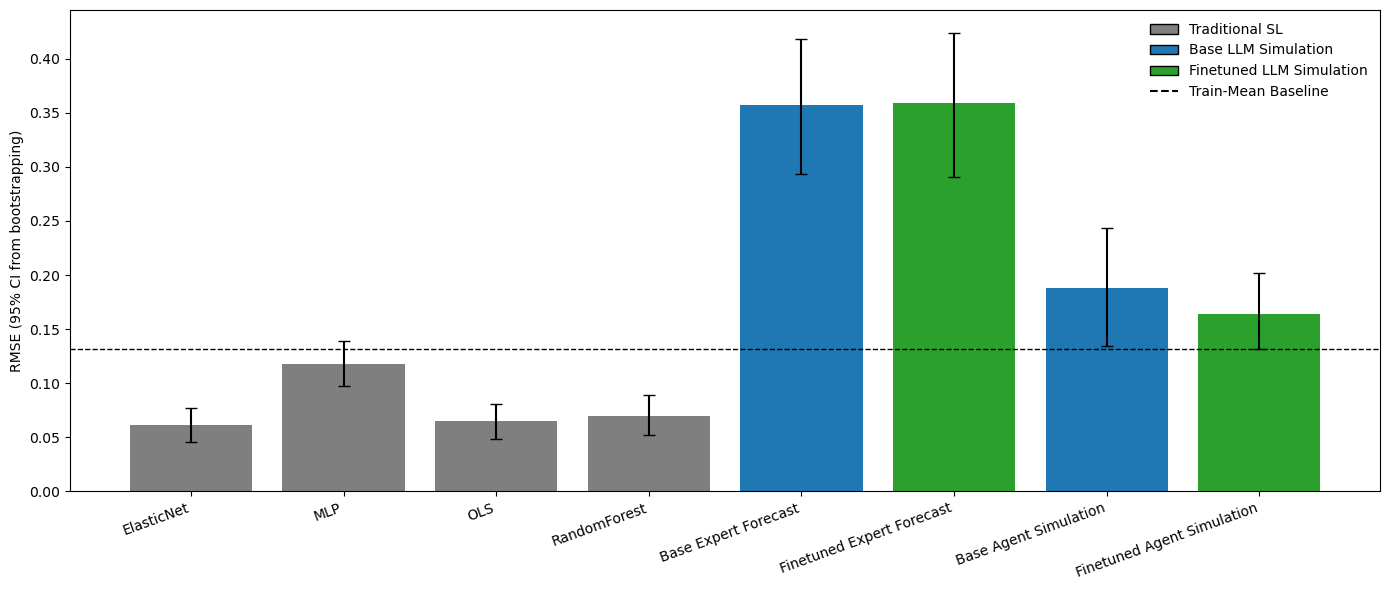

In [8]:
# ==========================================================
# RMSE bar plot with 95% bootstrapped confidence intervals
# Includes SL + LLM sims, with Train-Mean Baseline in legend
# ==========================================================
import pandas as pd, numpy as np, ast, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# ---------- paths ----------
PATH_SIMS = [
    ("base-obs", "output/llama31-8b-instruct-base-obs_2510142212.csv"),
    ("base-ptc", "output/llama31-8b-instruct-base-ptc_2510150020.csv"),
    ("lora-ptc", "output/llama31-8b-instruct-lora-ptc_2510142305.csv"),
    ("lora-obs", "output/llama31-8b-instruct-lora-obs_2510150133.csv"),
]

df_learn = pd.read_csv("data/processed_data/df_analysis_learn.csv")
df_val   = pd.read_csv("data/processed_data/df_analysis_val.csv")

# ---------- features & target ----------
CONFIG_COLS = [
    "CONFIG_playerCount","CONFIG_numRounds","CONFIG_showNRounds","CONFIG_MPCR",
    "CONFIG_allOrNothing","CONFIG_chat","CONFIG_defaultContribProp",
    "CONFIG_punishmentExists","CONFIG_rewardExists","CONFIG_showOtherSummaries",
    "CONFIG_showPunishmentId","CONFIG_punishmentCost","CONFIG_punishmentMagnitude",
    "CONFIG_rewardCost","CONFIG_rewardMagnitude"
]
TARGET_COL = "itt_efficiency"

# ---------- truth per config ----------
truth_val = (
    df_val[df_val["valid_number_of_starting_players"] == True]
    .groupby("name", as_index=False)[TARGET_COL]
    .mean()
    .rename(columns={"name":"gameId", TARGET_COL:"eff_truth"})
)

# ---------- helpers ----------
def parse_dict_cell(x):
    if isinstance(x, dict): return x
    if isinstance(x, str) and x.strip():
        try: return ast.literal_eval(x)
        except Exception: return {}
    return {}

def compute_game_efficiency(df_game: pd.DataFrame, cfg: pd.Series) -> float:
    endowment  = cfg.get("CONFIG_endowment", np.nan)
    multiplier = cfg.get("CONFIG_multiplier", np.nan)
    pun_cost   = cfg.get("CONFIG_punishmentCost", 0.0)
    pun_mag    = cfg.get("CONFIG_punishmentMagnitude", 0.0)
    rew_cost   = cfg.get("CONFIG_rewardCost", 0.0)
    rew_mag    = cfg.get("CONFIG_rewardMagnitude", 0.0)
    if pd.isna(endowment) or pd.isna(multiplier): return np.nan

    avatar_col, round_col = "playerAvatar", "roundIndex"
    contrib_col, punished_col, rewarded_col = "data.contribution","data.punished","data.rewarded"
    n_players = df_game[avatar_col].nunique()
    n_rounds  = df_game[round_col].nunique()

    total_payoff = 0.0
    for _, df_r in df_game.groupby(round_col):
        contrib_sum = df_r[contrib_col].sum()
        pot = contrib_sum * multiplier
        base = (endowment - df_r[contrib_col] + pot / n_players).copy()
        if punished_col in df_r.columns:
            for i, val in enumerate(df_r[punished_col]):
                d = parse_dict_cell(val)
                if not d: continue
                units = sum(d.values())
                base.iloc[i] -= pun_cost * units
                for target, u in d.items():
                    idx = (df_r[avatar_col] == target)
                    if idx.any(): base.loc[idx] -= pun_mag * u
        if rewarded_col in df_r.columns:
            for i, val in enumerate(df_r[rewarded_col]):
                d = parse_dict_cell(val)
                if not d: continue
                units = sum(d.values())
                base.iloc[i] -= rew_cost * units
                for target, u in d.items():
                    idx = (df_r[avatar_col] == target)
                    if idx.any(): base.loc[idx] += rew_mag * u
        total_payoff += float(base.sum())

    max_total = n_rounds * n_players * endowment * multiplier
    return total_payoff / max_total if max_total > 0 else np.nan

def bootstrap_rmse(se_array: np.ndarray, n_boot: int = 2000, rng=None):
    if rng is None: rng = np.random.default_rng(42)
    se_array = np.asarray(se_array)
    se_array = se_array[np.isfinite(se_array)]
    if se_array.size == 0:
        return np.nan, (np.nan, np.nan)
    rmse_hat = float(np.sqrt(se_array.mean()))
    n = se_array.size
    boots = np.empty(n_boot)
    for b in range(n_boot):
        idx = rng.integers(0, n, size=n)
        boots[b] = np.sqrt(se_array[idx].mean())
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return rmse_hat, (float(lo), float(hi))

# ---------- SL models ----------
Xtr = df_learn[CONFIG_COLS].copy()
ytr = df_learn[TARGET_COL].copy()
Xte = df_val[CONFIG_COLS].copy()
names_te = df_val["name"].copy()

mask_tr = ~Xtr.isna().any(axis=1) & ~ytr.isna()
mask_te = ~Xte.isna().any(axis=1) & names_te.notna()
Xtr, ytr = Xtr[mask_tr], ytr[mask_tr]
Xte, names_te = Xte[mask_te], names_te[mask_te]

models = {
    "ElasticNet":   ElasticNetCV(cv=5, l1_ratio=[.1,.5,.9], n_alphas=50, max_iter=5000, random_state=42),
    "MLP":          MLPRegressor(hidden_layer_sizes=(64,32), activation="relu", max_iter=2000, random_state=42),
    "OLS":          LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=500, random_state=42),
}

sl_se = {}
for mname, model in models.items():
    model.fit(Xtr, ytr)
    ypred = model.predict(Xte)
    df_pred = pd.DataFrame({"gameId": names_te.values, "y_pred": ypred})
    df_pred_cfg = df_pred.groupby("gameId", as_index=False)["y_pred"].mean()
    merged = df_pred_cfg.merge(truth_val, on="gameId", how="inner").dropna(subset=["y_pred","eff_truth"])
    sl_se[mname] = ((merged["y_pred"] - merged["eff_truth"])**2).to_numpy()

# ---------- LLM simulations ----------
cfg_by_name = df_val.groupby("name", as_index=True, sort=False).first()
def sim_sqerr_array(sim_path: str) -> np.ndarray:
    sim = pd.read_csv(sim_path)
    rows = []
    for gid, gdf in sim.groupby("gameId"):
        if gid not in cfg_by_name.index: continue
        eff_sim = compute_game_efficiency(gdf, cfg_by_name.loc[gid])
        rows.append({"gameId": gid, "eff_sim": eff_sim})
    if not rows: return np.array([])
    df_sim = pd.DataFrame(rows)
    merged = df_sim.merge(truth_val, on="gameId", how="inner").dropna(subset=["eff_sim","eff_truth"])
    return ((merged["eff_sim"] - merged["eff_truth"])**2).to_numpy()

sim_se = {key: sim_sqerr_array(path) for key, path in PATH_SIMS}

# ---------- bootstrap stats ----------
rng = np.random.default_rng(17)
def rmse_ci_dict(se_dict):
    stats = {}
    for k, arr in se_dict.items():
        rmse, (lo, hi) = bootstrap_rmse(arr, n_boot=2000, rng=rng)
        stats[k] = {"rmse": rmse, "lo": lo, "hi": hi}
    return stats

sl_stats  = rmse_ci_dict(sl_se)
sim_stats = rmse_ci_dict(sim_se)

# ---------- baseline RMSE ----------
ybar_train = float(df_learn[TARGET_COL].mean())
y_val_vec  = df_val[TARGET_COL].dropna().to_numpy()
baseline_rmse = float(np.sqrt(np.mean((y_val_vec - ybar_train)**2)))

# ---------- assemble plot ----------
labels_order = [
    "ElasticNet","MLP","OLS","RandomForest",
    "Base Expert Forecast","Finetuned Expert Forecast",
    "Base Agent Simulation","Finetuned Agent Simulation"
]
colors_order = [
    "#7f7f7f","#7f7f7f","#7f7f7f","#7f7f7f",
    "#1f77b4","#2ca02c","#1f77b4","#2ca02c"
]
sim_label_to_key = {
    "Base Expert Forecast": "base-obs",
    "Finetuned Expert Forecast": "lora-obs",
    "Base Agent Simulation": "base-ptc",
    "Finetuned Agent Simulation": "lora-ptc",
}

heights, yerr = [], []
for lab in labels_order:
    if lab in sl_stats:
        rmse, lo, hi = sl_stats[lab]["rmse"], sl_stats[lab]["lo"], sl_stats[lab]["hi"]
    else:
        k = sim_label_to_key[lab]
        rmse, lo, hi = sim_stats[k]["rmse"], sim_stats[k]["lo"], sim_stats[k]["hi"]
    heights.append(rmse)
    yerr.append([rmse - lo, hi - rmse])
yerr = np.array(yerr).T

# ---------- plot ----------
plt.figure(figsize=(14, 6))
x = np.arange(len(labels_order))
plt.bar(x, heights, color=colors_order, tick_label=labels_order, yerr=yerr, capsize=4)
plt.xticks(rotation=20, ha="right")
plt.ylabel("RMSE (95% CI from bootstrapping)")

# baseline line + legend
plt.axhline(baseline_rmse, linestyle="--", color="k", linewidth=1)

from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor="#7f7f7f", edgecolor="black", label="Traditional SL"),
    Patch(facecolor="#1f77b4", edgecolor="black", label="Base LLM Simulation"),
    Patch(facecolor="#2ca02c", edgecolor="black", label="Finetuned LLM Simulation"),
    plt.Line2D([0], [0], color="k", linestyle="--", label="Train-Mean Baseline")
]
plt.legend(handles=legend_handles, loc="upper right", frameon=False)

plt.tight_layout()
plt.show()

In [ ]:
compute_game_efficiency()

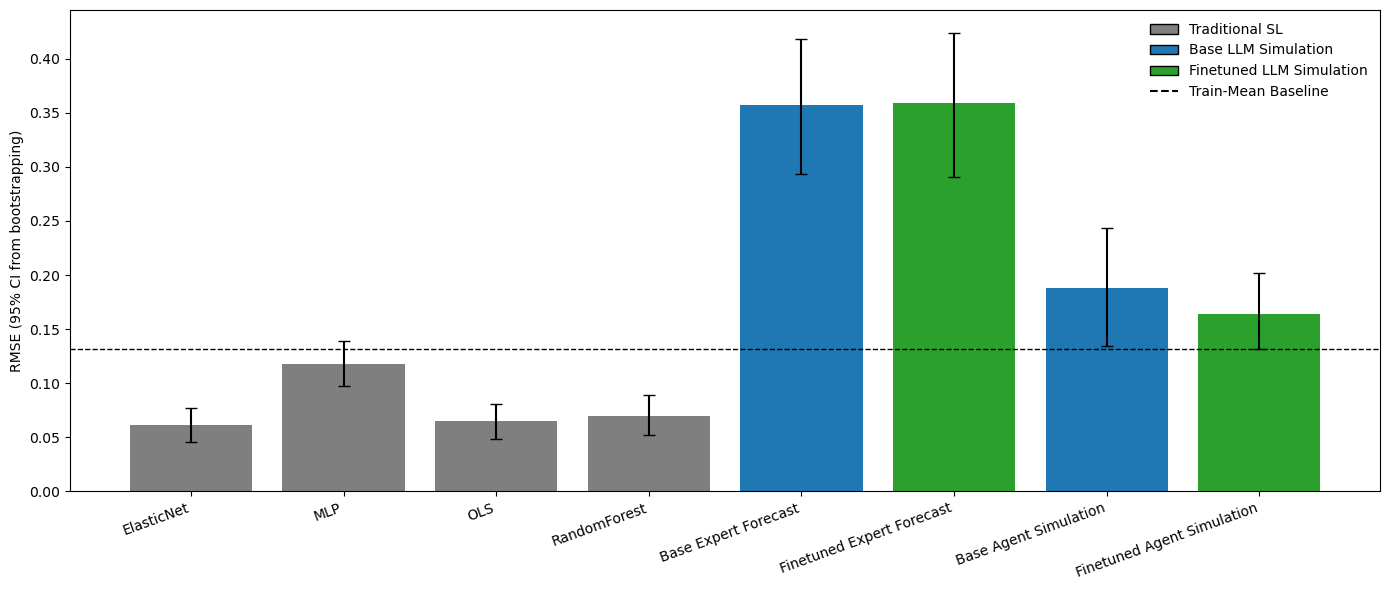

In [25]:
# ==========================================================
# RMSE bar plot with 95% bootstrapped confidence intervals
# Includes SL + LLM sims, with Train-Mean Baseline in legend
# ==========================================================
import pandas as pd, numpy as np, ast, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# ---------- paths ----------
PATH_SIMS = [
    ("base-obs", "output/llama31-8b-instruct-base-obs_2510142212.csv"),
    ("base-ptc", "output/llama31-8b-instruct-base-ptc_2510150020.csv"),
    ("lora-ptc", "output/llama31-8b-instruct-lora-ptc_2510142305.csv"),
    ("lora-obs", "output/llama31-8b-instruct-lora-obs_2510150133.csv"),
]

df_learn = pd.read_csv("data/processed_data/df_analysis_learn.csv")
df_val   = pd.read_csv("data/processed_data/df_analysis_val.csv")

# ---------- features & target ----------
CONFIG_COLS = [
    "CONFIG_playerCount","CONFIG_numRounds","CONFIG_showNRounds","CONFIG_MPCR",
    "CONFIG_allOrNothing","CONFIG_chat","CONFIG_defaultContribProp",
    "CONFIG_punishmentExists","CONFIG_rewardExists","CONFIG_showOtherSummaries",
    "CONFIG_showPunishmentId","CONFIG_punishmentCost","CONFIG_punishmentMagnitude",
    "CONFIG_rewardCost","CONFIG_rewardMagnitude"
]
TARGET_COL = "itt_efficiency"

# ---------- truth per config ----------
truth_val = (
    df_val[df_val["valid_number_of_starting_players"] == True]
    .groupby("name", as_index=False)[TARGET_COL]
    .mean()
    .rename(columns={"name":"gameId", TARGET_COL:"eff_truth"})
)

# ---------- helpers ----------
def parse_dict_cell(x):
    if isinstance(x, dict): return x
    if isinstance(x, str) and x.strip():
        try: return ast.literal_eval(x)
        except Exception: return {}
    return {}

def compute_game_efficiency(df_game: pd.DataFrame, cfg: pd.Series) -> float:
    endowment  = cfg.get("CONFIG_endowment", np.nan)
    multiplier = cfg.get("CONFIG_multiplier", np.nan)
    pun_cost   = cfg.get("CONFIG_punishmentCost", 0.0)
    pun_mag    = cfg.get("CONFIG_punishmentMagnitude", 0.0)
    rew_cost   = cfg.get("CONFIG_rewardCost", 0.0)
    rew_mag    = cfg.get("CONFIG_rewardMagnitude", 0.0)
    if pd.isna(endowment) or pd.isna(multiplier): return np.nan

    avatar_col, round_col = "playerAvatar", "roundIndex"
    contrib_col, punished_col, rewarded_col = "data.contribution","data.punished","data.rewarded"
    n_players = df_game[avatar_col].nunique()
    n_rounds  = df_game[round_col].nunique()

    total_payoff = 0.0
    for _, df_r in df_game.groupby(round_col):
        contrib_sum = df_r[contrib_col].sum()
        pot = contrib_sum * multiplier
        base = (endowment - df_r[contrib_col] + pot / n_players).copy()
        if punished_col in df_r.columns:
            for i, val in enumerate(df_r[punished_col]):
                d = parse_dict_cell(val)
                if not d: continue
                units = sum(d.values())
                base.iloc[i] -= pun_cost * units
                for target, u in d.items():
                    idx = (df_r[avatar_col] == target)
                    if idx.any(): base.loc[idx] -= pun_mag * u
        if rewarded_col in df_r.columns:
            for i, val in enumerate(df_r[rewarded_col]):
                d = parse_dict_cell(val)
                if not d: continue
                units = sum(d.values())
                base.iloc[i] -= rew_cost * units
                for target, u in d.items():
                    idx = (df_r[avatar_col] == target)
                    if idx.any(): base.loc[idx] += rew_mag * u
        total_payoff += float(base.sum())

    max_total = n_rounds * n_players * endowment * multiplier
    return total_payoff / max_total if max_total > 0 else np.nan

def bootstrap_rmse(se_array: np.ndarray, n_boot: int = 2000, rng=None):
    if rng is None: rng = np.random.default_rng(42)
    se_array = np.asarray(se_array)
    se_array = se_array[np.isfinite(se_array)]
    if se_array.size == 0:
        return np.nan, (np.nan, np.nan)
    rmse_hat = float(np.sqrt(se_array.mean()))
    n = se_array.size
    boots = np.empty(n_boot)
    for b in range(n_boot):
        idx = rng.integers(0, n, size=n)
        boots[b] = np.sqrt(se_array[idx].mean())
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return rmse_hat, (float(lo), float(hi))

# ---------- SL models ----------
Xtr = df_learn[CONFIG_COLS].copy()
ytr = df_learn[TARGET_COL].copy()
Xte = df_val[CONFIG_COLS].copy()
names_te = df_val["name"].copy()

mask_tr = ~Xtr.isna().any(axis=1) & ~ytr.isna()
mask_te = ~Xte.isna().any(axis=1) & names_te.notna()
Xtr, ytr = Xtr[mask_tr], ytr[mask_tr]
Xte, names_te = Xte[mask_te], names_te[mask_te]

models = {
    "ElasticNet":   ElasticNetCV(cv=5, l1_ratio=[.1,.5,.9], n_alphas=50, max_iter=5000, random_state=42),
    "MLP":          MLPRegressor(hidden_layer_sizes=(64,32), activation="relu", max_iter=2000, random_state=42),
    "OLS":          LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=500, random_state=42),
}

sl_se = {}
for mname, model in models.items():
    model.fit(Xtr, ytr)
    ypred = model.predict(Xte)
    df_pred = pd.DataFrame({"gameId": names_te.values, "y_pred": ypred})
    df_pred_cfg = df_pred.groupby("gameId", as_index=False)["y_pred"].mean()
    merged = df_pred_cfg.merge(truth_val, on="gameId", how="inner").dropna(subset=["y_pred","eff_truth"])
    sl_se[mname] = ((merged["y_pred"] - merged["eff_truth"])**2).to_numpy()

# ---------- LLM simulations ----------
cfg_by_name = df_val.groupby("name", as_index=True, sort=False).first()
def sim_sqerr_array(sim_path: str) -> np.ndarray:
    sim = pd.read_csv(sim_path)
    rows = []
    for gid, gdf in sim.groupby("gameId"):
        if gid not in cfg_by_name.index: continue
        eff_sim = compute_game_efficiency(gdf, cfg_by_name.loc[gid])
        rows.append({"gameId": gid, "eff_sim": eff_sim})
    if not rows: return np.array([])
    df_sim = pd.DataFrame(rows)
    merged = df_sim.merge(truth_val, on="gameId", how="inner").dropna(subset=["eff_sim","eff_truth"])
    return ((merged["eff_sim"] - merged["eff_truth"])**2).to_numpy()

sim_se = {key: sim_sqerr_array(path) for key, path in PATH_SIMS}

# ---------- bootstrap stats ----------
rng = np.random.default_rng(17)
def rmse_ci_dict(se_dict):
    stats = {}
    for k, arr in se_dict.items():
        rmse, (lo, hi) = bootstrap_rmse(arr, n_boot=2000, rng=rng)
        stats[k] = {"rmse": rmse, "lo": lo, "hi": hi}
    return stats

sl_stats  = rmse_ci_dict(sl_se)
sim_stats = rmse_ci_dict(sim_se)

# ---------- baseline RMSE ----------
ybar_train = float(df_learn[TARGET_COL].mean())
y_val_vec  = df_val[TARGET_COL].dropna().to_numpy()
baseline_rmse = float(np.sqrt(np.mean((y_val_vec - ybar_train)**2)))

# ---------- assemble plot ----------
labels_order = [
    "ElasticNet","MLP","OLS","RandomForest",
    "Base Expert Forecast","Finetuned Expert Forecast",
    "Base Agent Simulation","Finetuned Agent Simulation"
]
colors_order = [
    "#7f7f7f","#7f7f7f","#7f7f7f","#7f7f7f",
    "#1f77b4","#2ca02c","#1f77b4","#2ca02c"
]
sim_label_to_key = {
    "Base Expert Forecast": "base-obs",
    "Finetuned Expert Forecast": "lora-obs",
    "Base Agent Simulation": "base-ptc",
    "Finetuned Agent Simulation": "lora-ptc",
}

heights, yerr = [], []
for lab in labels_order:
    if lab in sl_stats:
        rmse, lo, hi = sl_stats[lab]["rmse"], sl_stats[lab]["lo"], sl_stats[lab]["hi"]
    else:
        k = sim_label_to_key[lab]
        rmse, lo, hi = sim_stats[k]["rmse"], sim_stats[k]["lo"], sim_stats[k]["hi"]
    heights.append(rmse)
    yerr.append([rmse - lo, hi - rmse])
yerr = np.array(yerr).T

# ---------- plot ----------
plt.figure(figsize=(14, 6))
x = np.arange(len(labels_order))
plt.bar(x, heights, color=colors_order, tick_label=labels_order, yerr=yerr, capsize=4)
plt.xticks(rotation=20, ha="right")
plt.ylabel("RMSE (95% CI from bootstrapping)")

# baseline line + legend
plt.axhline(baseline_rmse, linestyle="--", color="k", linewidth=1)

from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor="#7f7f7f", edgecolor="black", label="Traditional SL"),
    Patch(facecolor="#1f77b4", edgecolor="black", label="Base LLM Simulation"),
    Patch(facecolor="#2ca02c", edgecolor="black", label="Finetuned LLM Simulation"),
    plt.Line2D([0], [0], color="k", linestyle="--", label="Train-Mean Baseline")
]
plt.legend(handles=legend_handles, loc="upper right", frameon=False)

plt.tight_layout()
plt.show()

In [9]:
# ==========================================================
# Compare Base Agent Simulation vs Finetuned Agent Simulation
# ==========================================================
import pandas as pd, numpy as np
from scipy.stats import wilcoxon
import statsmodels.formula.api as smf

# --- Build per-config RMSEs --------------------------------
cfg_by_name = df_val.groupby("name", as_index=True, sort=False).first()
truth_cfg = (
    df_val[df_val["valid_number_of_starting_players"] == True]
    .groupby("name", as_index=False)[TARGET_COL]
    .mean()
    .rename(columns={"name":"gameId", TARGET_COL:"eff_truth"})
)

def per_config_rmse(sim_path):
    sim = pd.read_csv(sim_path)
    rows = []
    for gid, gdf in sim.groupby("gameId"):
        if gid not in cfg_by_name.index: continue
        eff = compute_game_efficiency(gdf, cfg_by_name.loc[gid])
        rows.append({"gameId": gid, "eff_pred": eff})
    if not rows: return pd.DataFrame(columns=["gameId","rmse"])
    df_pred = pd.DataFrame(rows)
    merged = df_pred.merge(truth_cfg, on="gameId", how="inner").dropna(subset=["eff_pred","eff_truth"])
    rmse = np.sqrt((merged["eff_pred"] - merged["eff_truth"])**2)
    merged["rmse"] = rmse
    return merged[["gameId","rmse"]]

df_base = per_config_rmse("output/llama31-8b-instruct-base-ptc_2510150020.csv")
df_ft   = per_config_rmse("output/llama31-8b-instruct-lora-ptc_2510142305.csv")

# --- Merge and paired deltas -------------------------------
df_pair = df_base.merge(df_ft, on="gameId", suffixes=("_base","_ft"))
df_pair["delta"] = df_pair["rmse_ft"] - df_pair["rmse_base"]   # negative = improvement
n_cfg = len(df_pair)

# --- Paired difference bootstrap CI ------------------------
rng = np.random.default_rng(0)
B = 5000
boot = [df_pair.sample(frac=1, replace=True, random_state=rng).delta.mean() for _ in range(B)]
ci_lo, ci_hi = np.percentile(boot, [2.5,97.5])
mean_diff = df_pair["delta"].mean()

print(f"ΔRMSE (FT−Base): {mean_diff:+.4f}  95% CI [{ci_lo:+.4f},{ci_hi:+.4f}]  (n={n_cfg} configs)")

# --- Win rate (fraction of configs where FT better) --------
wins = (df_pair["delta"] < 0).sum()
p_hat = wins / n_cfg
# Wilson CI
z=1.96
den=1+z**2/n_cfg
center=(p_hat+z*z/(2*n_cfg))/den
half=(z/den)*np.sqrt((p_hat*(1-p_hat)/n_cfg)+(z*z/(4*n_cfg*n_cfg)))
ci_lo_w, ci_hi_w = center-half, center+half
print(f"Win rate: {p_hat:.2%}  (95% CI {ci_lo_w:.2%}–{ci_hi_w:.2%})")

# --- Mixed-effects model accounting for heterogeneity ------
df_long = pd.concat([
    df_pair[["gameId","rmse_base"]].rename(columns={"rmse_base":"rmse"}).assign(method="Base"),
    df_pair[["gameId","rmse_ft"]].rename(columns={"rmse_ft":"rmse"}).assign(method="Finetuned")
])
md = smf.mixedlm("rmse ~ C(method)", df_long, groups=df_long["gameId"])
mfit = md.fit(reml=True)
print(mfit.summary().tables[1])

# Extract key quantities
beta = float(mfit.params.get("C(method)[T.Finetuned]", np.nan))
ci_low, ci_high = mfit.conf_int().loc["C(method)[T.Finetuned]"]
print(f"Pooled improvement (Finetuned−Base): {beta:+.4f}  95% CI [{ci_low:+.4f},{ci_high:+.4f}]")

ΔRMSE (FT−Base): -0.0107  95% CI [-0.0457,+0.0207]  (n=40 configs)
Win rate: 47.50%  (95% CI 32.94%–62.50%)
                         Coef. Std.Err.       z  P>|z|  [0.025 0.975]
Intercept                0.143    0.018   8.186  0.000   0.109  0.178
C(method)[T.Finetuned]  -0.011    0.017  -0.613  0.540  -0.045  0.024
Group Var                0.006    0.038                              
Pooled improvement (Finetuned−Base): -0.0107  95% CI [-0.0450,+0.0235]


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


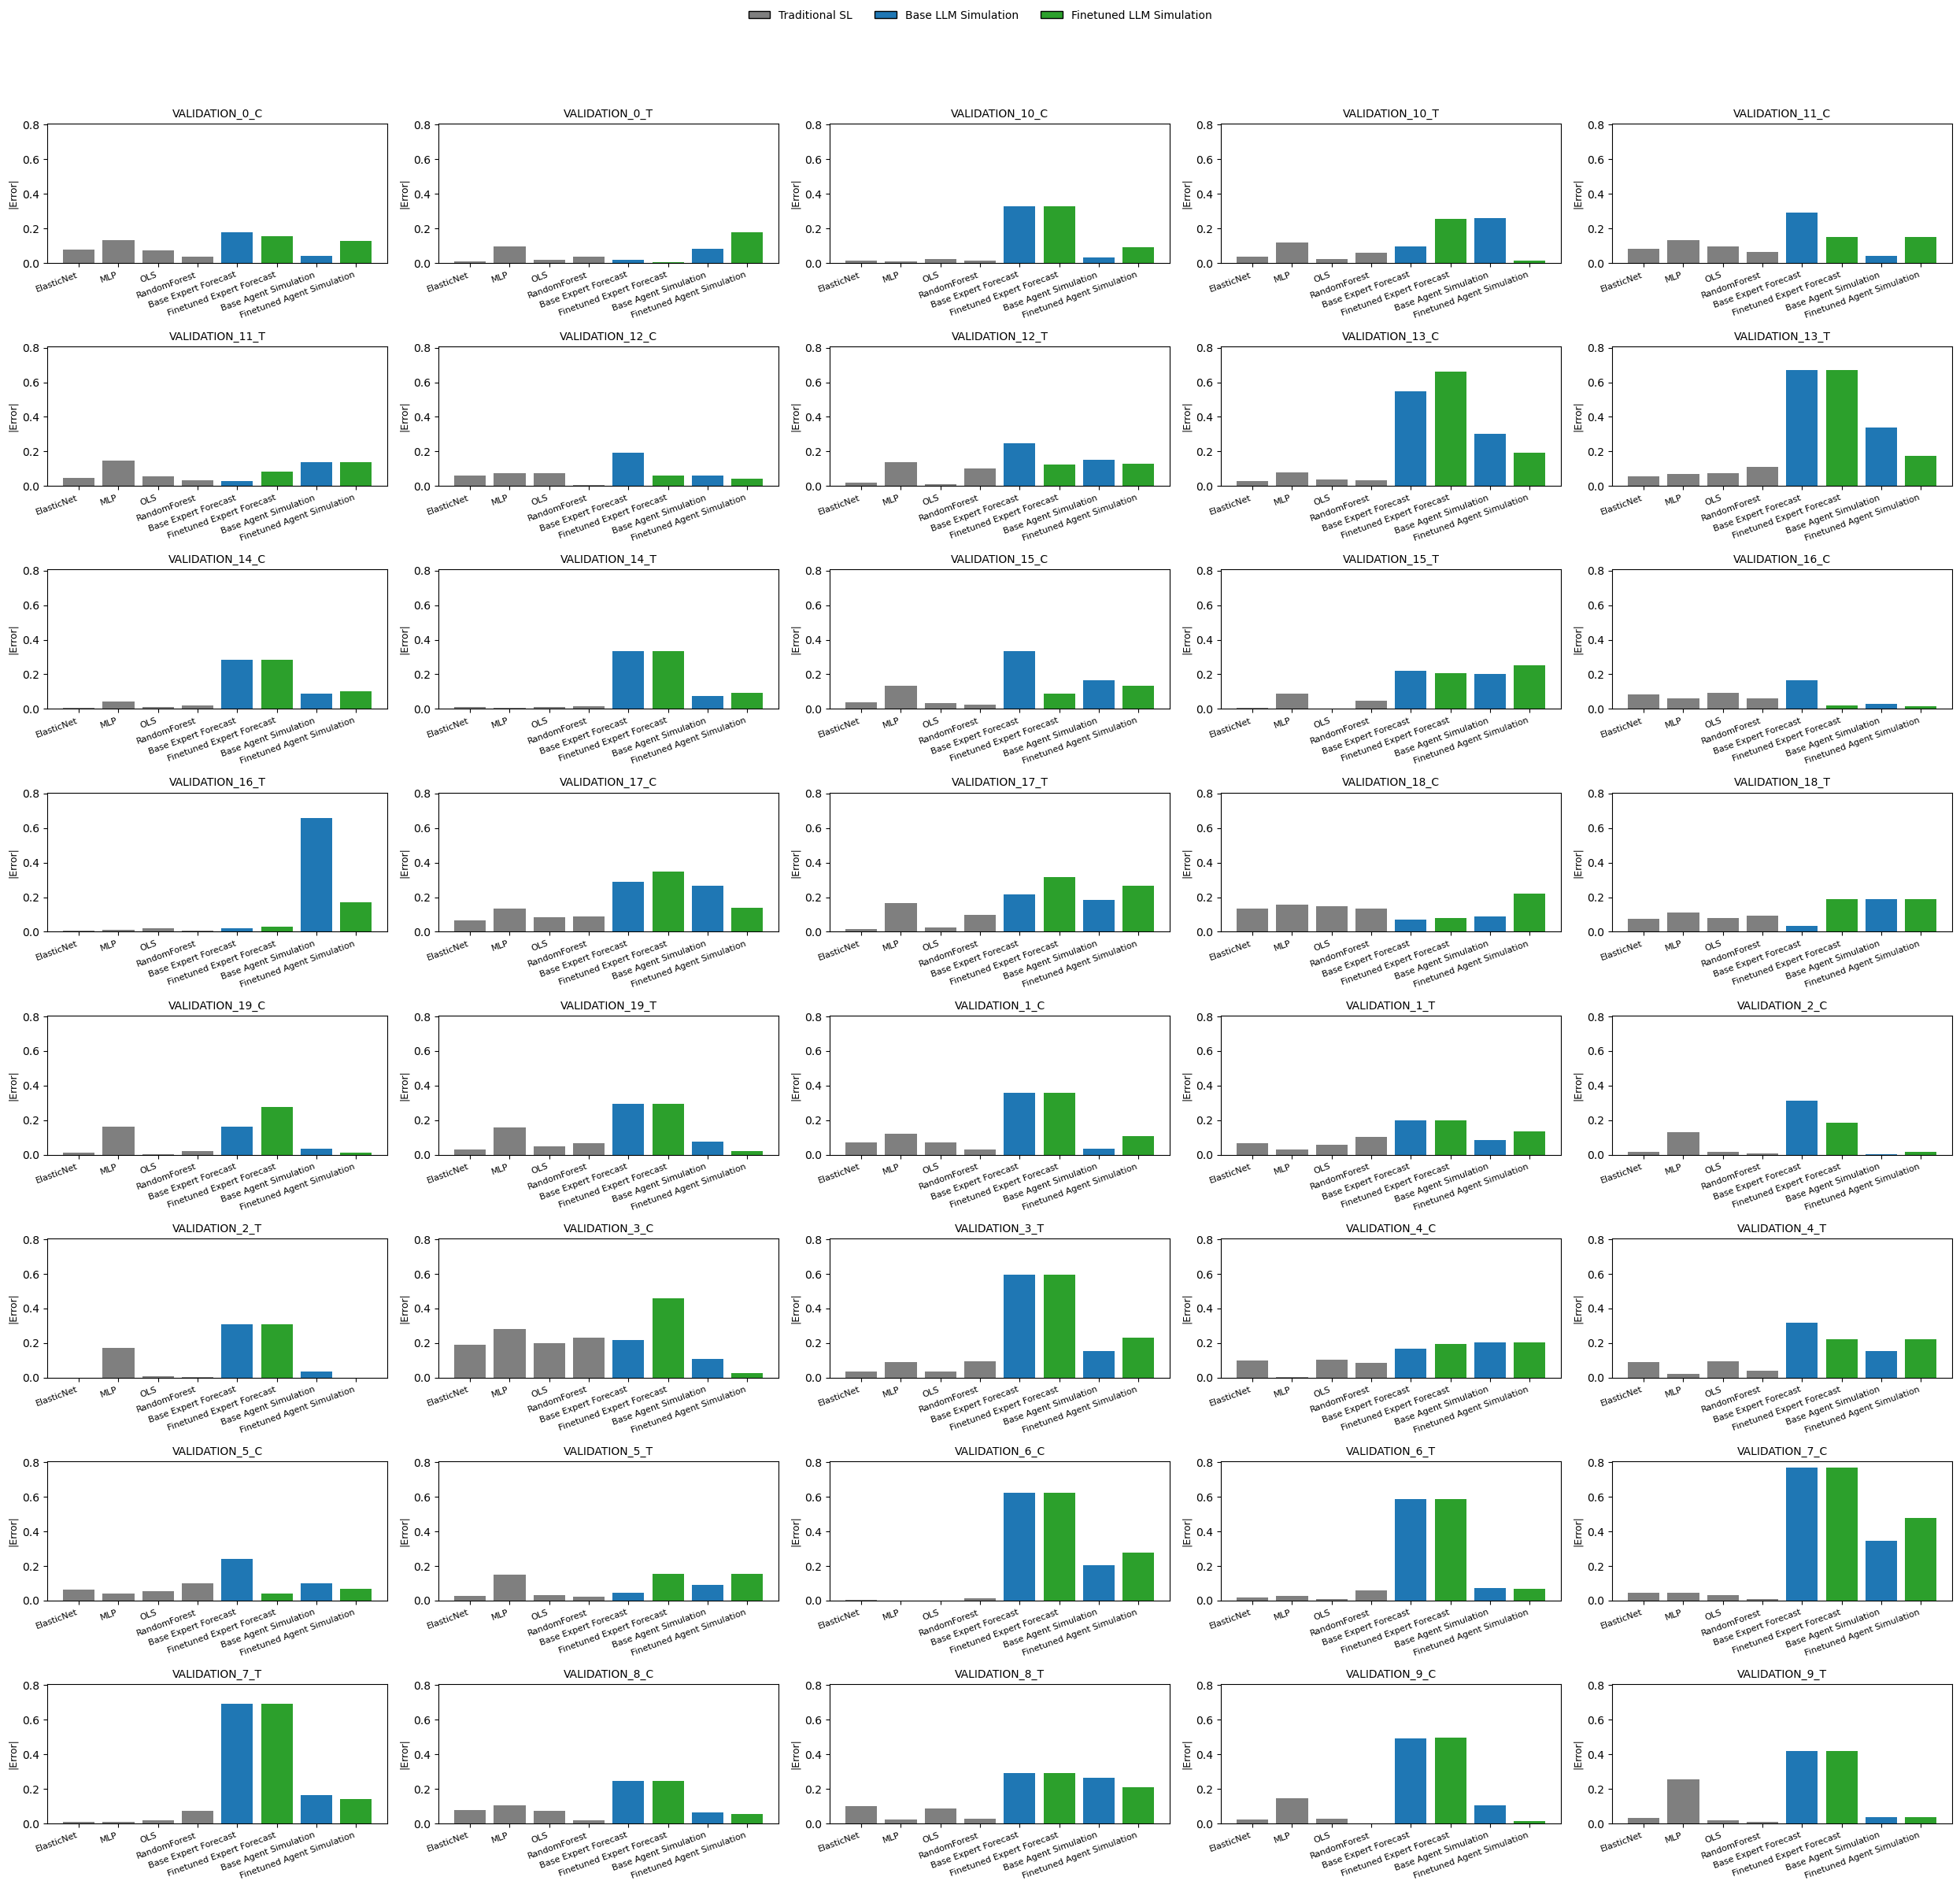

In [50]:
# ==========================================================
# Per-config bar plots of RMSE (|y_hat - y|), df_val ground truth
# Panels: one per configuration (≈40 panels)
# Bars per panel (left→right):
#   ElasticNet, MLP, OLS, RandomForest,
#   Base Expert, Finetuned Expert, Base Agent, Finetuned Agent
# Colors: SL=gray, Base=blue, Finetuned=green
# ==========================================================
import pandas as pd, numpy as np, ast, math, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# ---------- Paths (update if needed) ----------
PATH_SIMS = [
    ("base-obs", "output/llama31-8b-instruct-base-obs_2510142212.csv"),
    ("base-ptc", "output/llama31-8b-instruct-base-ptc_2510150020.csv"),
    ("lora-ptc", "output/llama31-8b-instruct-lora-ptc_2510142305.csv"),
    ("lora-obs", "output/llama31-8b-instruct-lora-obs_2510150133.csv"),
]

df_learn = pd.read_csv("data/processed_data/df_analysis_learn.csv")
df_val   = pd.read_csv("data/processed_data/df_analysis_val.csv")

# ---------- Truth per config on df_val ----------
mask_valid = df_val["valid_number_of_starting_players"] == True if "valid_number_of_starting_players" in df_val.columns else np.ones(len(df_val), dtype=bool)
truth_val = (
    df_val.loc[mask_valid, ["name", "itt_efficiency"]]
    .groupby("name", as_index=False)["itt_efficiency"]
    .mean()
    .rename(columns={"name":"gameId","itt_efficiency":"eff_truth"})
)

# ---------- Features for SL ----------
CONFIG_COLS = [
    "CONFIG_playerCount","CONFIG_numRounds","CONFIG_showNRounds","CONFIG_MPCR",
    "CONFIG_allOrNothing","CONFIG_chat","CONFIG_defaultContribProp",
    "CONFIG_punishmentExists","CONFIG_rewardExists","CONFIG_showOtherSummaries",
    "CONFIG_showPunishmentId","CONFIG_punishmentCost","CONFIG_punishmentMagnitude",
    "CONFIG_rewardCost","CONFIG_rewardMagnitude"
]
TARGET_COL = "itt_efficiency"

# Train on df_learn; predict on df_val
Xtr = df_learn[CONFIG_COLS].copy()
ytr = df_learn[TARGET_COL].copy()
Xte = df_val[CONFIG_COLS].copy()
names_te = df_val["name"].copy()

mask_tr = ~Xtr.isna().any(axis=1) & ~ytr.isna()
mask_te = ~Xte.isna().any(axis=1) & names_te.notna()
Xtr, ytr = Xtr[mask_tr], ytr[mask_tr]
Xte, names_te = Xte[mask_te], names_te[mask_te]

sl_models = {
    "ElasticNet":   ElasticNetCV(cv=5, l1_ratio=[.1,.5,.9], n_alphas=50, max_iter=5000, random_state=42),
    "MLP":          MLPRegressor(hidden_layer_sizes=(64,32), activation="relu", max_iter=2000, random_state=42),
    "OLS":          LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=500, random_state=42),
}

# Per-config absolute error for SL (on df_val)
sl_err_percfg = []  # rows: {"gameId", "Model", "abs_err"}
for mname, model in sl_models.items():
    model.fit(Xtr, ytr)
    yhat = model.predict(Xte)
    df_pred = pd.DataFrame({"gameId": names_te.values, "y_pred": yhat})
    df_pred_cfg = df_pred.groupby("gameId", as_index=False)["y_pred"].mean()
    m = df_pred_cfg.merge(truth_val, on="gameId", how="inner").dropna(subset=["y_pred","eff_truth"])
    m["abs_err"] = (m["y_pred"] - m["eff_truth"]).abs()
    sl_err_percfg.append(m[["gameId","abs_err"]].assign(Model=mname))

sl_err_percfg = pd.concat(sl_err_percfg, ignore_index=True) if sl_err_percfg else pd.DataFrame(columns=["gameId","abs_err","Model"])

# ---------- Simulation: per-config efficiency on df_val ----------
cfg_by_name = (df_val.groupby("name", as_index=True, sort=False).first())

def parse_dict_cell(x):
    if isinstance(x, dict): return x
    if isinstance(x, str) and x.strip():
        try: return ast.literal_eval(x)
        except Exception: return {}
    return {}

def compute_game_efficiency(df_game: pd.DataFrame, cfg_row: pd.Series) -> float:
    E  = cfg_row.get("CONFIG_endowment", np.nan)
    M  = cfg_row.get("CONFIG_multiplier", np.nan)
    pc = cfg_row.get("CONFIG_punishmentCost", 0.0)
    pm = cfg_row.get("CONFIG_punishmentMagnitude", 0.0)
    rc = cfg_row.get("CONFIG_rewardCost", 0.0)
    rm = cfg_row.get("CONFIG_rewardMagnitude", 0.0)
    if pd.isna(E) or pd.isna(M): return np.nan

    acol, rcol = "playerAvatar", "roundIndex"
    ccol, pcol, rwdcol = "data.contribution", "data.punished", "data.rewarded"
    n = df_game[acol].nunique()
    R = df_game[rcol].nunique()

    total_payoff = 0.0
    for _, g in df_game.groupby(rcol):
        pot = g[ccol].fillna(0).sum() * M
        base = (E - g[ccol].fillna(0) + pot / n).copy()

        if pcol in g.columns:
            for i, v in enumerate(g[pcol].fillna("{}").astype(str)):
                d = parse_dict_cell(v)
                if d:
                    units = sum(d.values())
                    base.iloc[i] -= pc * units
                    for tgt, u in d.items():
                        idx = (g[acol] == tgt)
                        if idx.any(): base.loc[idx] -= pm * u

        if rwdcol in g.columns:
            for i, v in enumerate(g[rwdcol].fillna("{}").astype(str)):
                d = parse_dict_cell(v)
                if d:
                    units = sum(d.values())
                    base.iloc[i] -= rc * units
                    for tgt, u in d.items():
                        idx = (g[acol] == tgt)
                        if idx.any(): base.loc[idx] += rm * u

        total_payoff += float(base.sum())

    max_total = R * n * E * M
    return total_payoff / max_total if max_total > 0 else np.nan

sim_err_percfg = []  # rows: {"gameId","abs_err","Model"}
sim_label_map = {
    "base-obs": "Base Expert Forecast",
    "lora-obs": "Finetuned Expert Forecast",
    "base-ptc": "Base Agent Simulation",
    "lora-ptc": "Finetuned Agent Simulation",
}
for key, path in PATH_SIMS:
    sim = pd.read_csv(path)
    rows = []
    for gid, g in sim.groupby("gameId"):  # NOTE: sim 'gameId' aligns with df_val['name']
        if gid not in cfg_by_name.index:
            continue
        eff_sim = compute_game_efficiency(g, cfg_by_name.loc[gid])
        rows.append({"gameId": gid, "eff_sim": eff_sim})
    if not rows:
        continue
    df_sim_eff = pd.DataFrame(rows).merge(truth_val, on="gameId", how="inner").dropna(subset=["eff_sim","eff_truth"])
    df_sim_eff["abs_err"] = (df_sim_eff["eff_sim"] - df_sim_eff["eff_truth"]).abs()
    sim_err_percfg.append(df_sim_eff[["gameId","abs_err"]].assign(Model=sim_label_map.get(key, key)))

sim_err_percfg = pd.concat(sim_err_percfg, ignore_index=True) if sim_err_percfg else pd.DataFrame(columns=["gameId","abs_err","Model"])

# ---------- Combine SL + SIM into a long table ----------
long_err = pd.concat([sl_err_percfg, sim_err_percfg], ignore_index=True)

# ---------- Consistent order & colors ----------
label_order = [
    "ElasticNet","MLP","OLS","RandomForest",
    "Base Expert Forecast","Finetuned Expert Forecast",
    "Base Agent Simulation","Finetuned Agent Simulation"
]
color_map = {
    "ElasticNet": "#7f7f7f", "MLP": "#7f7f7f", "OLS": "#7f7f7f", "RandomForest": "#7f7f7f",
    "Base Expert Forecast": "#1f77b4", "Finetuned Expert Forecast": "#2ca02c",
    "Base Agent Simulation": "#1f77b4", "Finetuned Agent Simulation": "#2ca02c",
}

# Keep only configs present in truth_val (order stable)
configs = truth_val["gameId"].tolist()

# ---------- Plot grid of small bar charts ----------
n_cfg = len(configs)
cols = 5
rows = math.ceil(n_cfg / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3), squeeze=False)
global_ymax = np.nanmax(long_err["abs_err"]) * 1.05   # add 5% headroom

for i, gid in enumerate(configs):
    r, c = divmod(i, cols)
    ax = axes[r][c]
    df_i = long_err[long_err["gameId"] == gid]
    # align to fixed order
    heights = [df_i.loc[df_i["Model"]==lab, "abs_err"].values[0] if (df_i["Model"]==lab).any() else np.nan
               for lab in label_order]
    x = np.arange(len(label_order))
    colors = [color_map[lab] for lab in label_order]
    ax.bar(x, heights, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(label_order, rotation=20, ha="right", fontsize=8)
    ax.set_ylabel("|Error|", fontsize=9)
    ax.set_ylim(0, global_ymax)
    ax.set_title(gid, fontsize=10)
    # optional: y-limit harmonization across panels
    # ax.set_ylim(0, 1.0)

# Hide any unused axes
for j in range(i+1, rows*cols):
    r, c = divmod(j, cols)
    axes[r][c].axis("off")

# Shared legend (once)
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor="#7f7f7f", edgecolor="black", label="Traditional SL"),
    Patch(facecolor="#1f77b4", edgecolor="black", label="Base LLM Simulation"),
    Patch(facecolor="#2ca02c", edgecolor="black", label="Finetuned LLM Simulation"),
]
fig.legend(handles=legend_handles, loc="upper center", ncol=3, frameon=False)

plt.tight_layout(rect=(0,0,1,0.95))
plt.show()

In [40]:
len(pd.read_csv("output/llama31-8b-instruct-base-ptc-train_2510151002.csv").gameId.unique())

39

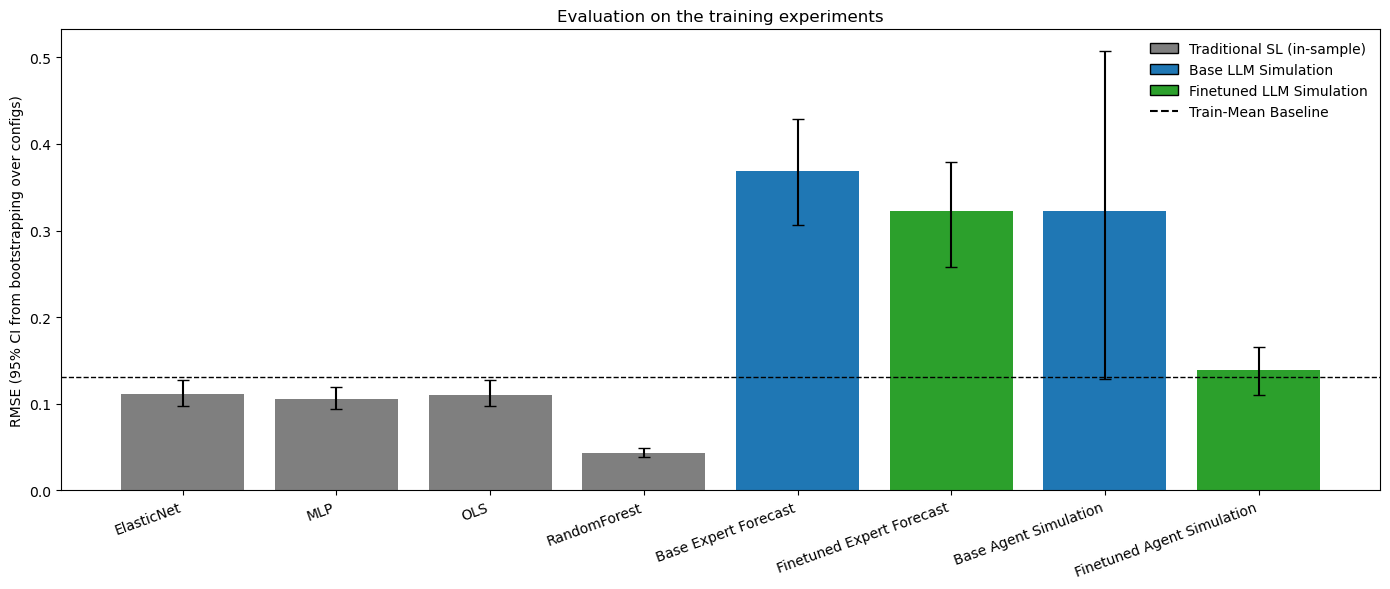

In [16]:
# ==========================================================
# RMSE bar plot (with 95% CIs via bootstrap) using df_learn as ground truth
# - Accepts ANY list of simulation CSVs: PATH_SIMS = [(key, path), ...]
# - Ground truth: df_learn (averaged per config if duplicates)
# - Bars: RMSE; Error bars: 95% CI of RMSE (bootstrap over configs)
# - Legend: Traditional SL (optional block), Base LLM Sim (blue), Finetuned LLM Sim (green), Train-Mean Baseline
# - No files saved
# ==========================================================
import pandas as pd, numpy as np, ast, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# --------------------
# 1) EDIT THIS LIST
# --------------------
# Example: replace with your new list for the LEARN set
PATH_SIMS = [
    
    ("base-obs", "output/llama31-8b-instruct-base-obs-train_2510151454.csv"),
    ("lora-obs", "output/llama31-8b-instruct-lora-obs-train_2510151343.csv"),
    ("base-ptc", "output/llama31-8b-instruct-base-ptc-train_2510151002.csv"),
    ("lora-ptc", "output/llama31-8b-instruct-lora-ptc-train_2510151136.csv"),
]

# --------------------
# 2) LOAD GROUND TRUTH
# --------------------
df_learn = pd.read_csv("data/processed_data/df_analysis_learn.csv")

# Truth per configuration (config key = 'name' in your tables)
# If df_learn has 'valid_number_of_starting_players', we’ll respect it; else we’ll use all rows.
mask_valid = df_learn["valid_number_of_starting_players"] == True if "valid_number_of_starting_players" in df_learn.columns else np.ones(len(df_learn), dtype=bool)
truth_learn = (
    df_learn.loc[mask_valid, ["name", "itt_efficiency"]]
    .groupby("name", as_index=False)["itt_efficiency"]
    .mean()
    .rename(columns={"name": "gameId", "itt_efficiency": "eff_truth"})
)
# config params to compute theoretical max, etc., if needed later
cfg_by_name = (df_learn.groupby("name", as_index=True, sort=False).first())

# --------------------
# 3) SIM → per-config efficiencies
# --------------------
def parse_dict_cell(x):
    if isinstance(x, dict): return x
    if isinstance(x, str) and x.strip():
        try:
            return ast.literal_eval(x)
        except Exception:
            return {}
    return {}

def compute_game_efficiency(df_game: pd.DataFrame, cfg_row: pd.Series) -> float:
    """Simulated efficiency for one game based on contributions + incentives."""
    E  = cfg_row.get("CONFIG_endowment", np.nan)
    M  = cfg_row.get("CONFIG_multiplier", np.nan)
    pc = cfg_row.get("CONFIG_punishmentCost", 0.0)
    pm = cfg_row.get("CONFIG_punishmentMagnitude", 0.0)
    rc = cfg_row.get("CONFIG_rewardCost", 0.0)
    rm = cfg_row.get("CONFIG_rewardMagnitude", 0.0)
    if pd.isna(E) or pd.isna(M): return np.nan

    acol, rcol = "playerAvatar", "roundIndex"
    ccol, pcol, rwdcol = "data.contribution", "data.punished", "data.rewarded"
    n = df_game[acol].nunique()
    R = df_game[rcol].nunique()

    total_payoff = 0.0
    for _, g in df_game.groupby(rcol):
        pot = g[ccol].fillna(0).sum() * M
        base = (E - g[ccol].fillna(0) + pot / n).copy()

        if pcol in g.columns:
            for i, v in enumerate(g[pcol].fillna("{}").astype(str)):
                d = parse_dict_cell(v)
                if d:
                    units = sum(d.values())
                    base.iloc[i] -= pc * units
                    for tgt, u in d.items():
                        idx = (g[acol] == tgt)
                        if idx.any(): base.loc[idx] -= pm * u

        if rwdcol in g.columns:
            for i, v in enumerate(g[rwdcol].fillna("{}").astype(str)):
                d = parse_dict_cell(v)
                if d:
                    units = sum(d.values())
                    base.iloc[i] -= rc * units
                    for tgt, u in d.items():
                        idx = (g[acol] == tgt)
                        if idx.any(): base.loc[idx] += rm * u

        total_payoff += float(base.sum())

    max_total = R * n * E * M
    return total_payoff / max_total if max_total > 0 else np.nan

def sim_sqerr_array(sim_path: str) -> np.ndarray:
    """Return per-config squared errors vs LEARN ground truth for one sim CSV."""
    sim = pd.read_csv(sim_path)
    if sim.empty:
        return np.array([])
    rows = []
    for gid, g in sim.groupby("gameId"):  # NOTE: in sims, gameId aligns with df_learn['name']
        if gid not in cfg_by_name.index: 
            continue
        eff_sim = compute_game_efficiency(g, cfg_by_name.loc[gid])
        rows.append({"gameId": gid, "eff_sim": eff_sim})
    if not rows:
        return np.array([])
    df_sim = pd.DataFrame(rows)
    merged = df_sim.merge(truth_learn, on="gameId", how="inner").dropna(subset=["eff_sim","eff_truth"])
    return ((merged["eff_sim"] - merged["eff_truth"])**2).to_numpy()

# Collect per-sim squared error arrays
sim_se = {key: sim_sqerr_array(path) for key, path in PATH_SIMS}

# --------------------
# 4) Bootstrap RMSE CIs
# --------------------
def bootstrap_rmse(se_array: np.ndarray, n_boot: int = 2000, rng=None):
    if rng is None: rng = np.random.default_rng(42)
    se = np.asarray(se_array)
    se = se[np.isfinite(se)]
    if se.size == 0:
        return np.nan, (np.nan, np.nan), 0
    rmse_hat = float(np.sqrt(se.mean()))
    n = se.size
    boots = np.empty(n_boot)
    for b in range(n_boot):
        idx = rng.integers(0, n, size=n)
        boots[b] = np.sqrt(se[idx].mean())
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return rmse_hat, (float(lo), float(hi)), n

rng = np.random.default_rng(17)
sim_stats = {}
for k, arr in sim_se.items():
    rmse, (lo, hi), n = bootstrap_rmse(arr, n_boot=2000, rng=rng)
    sim_stats[k] = {"rmse": rmse, "lo": lo, "hi": hi, "n": n}

# --------------------
# 5) Optional: SL baselines trained & evaluated on LEARN
# --------------------
# Comment out this block if you ONLY want the sims.
CONFIG_COLS = [
    "CONFIG_playerCount","CONFIG_numRounds","CONFIG_showNRounds","CONFIG_MPCR",
    "CONFIG_allOrNothing","CONFIG_chat","CONFIG_defaultContribProp",
    "CONFIG_punishmentExists","CONFIG_rewardExists","CONFIG_showOtherSummaries",
    "CONFIG_showPunishmentId","CONFIG_punishmentCost","CONFIG_punishmentMagnitude",
    "CONFIG_rewardCost","CONFIG_rewardMagnitude"
]
TARGET_COL = "itt_efficiency"

X = df_learn[CONFIG_COLS].copy()
y = df_learn[TARGET_COL].copy()
mask = ~X.isna().any(axis=1) & ~y.isna()
X, y = X[mask], y[mask]
names_learn = df_learn.loc[mask, "name"].reset_index(drop=True)

sl_models = {
    "ElasticNet":   ElasticNetCV(cv=5, l1_ratio=[.1,.5,.9], n_alphas=50, max_iter=5000, random_state=42),
    "MLP":          MLPRegressor(hidden_layer_sizes=(64,32), activation="relu", max_iter=2000, random_state=42),
    "OLS":          LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=500, random_state=42),
}
sl_se = {}
for mname, model in sl_models.items():
    model.fit(X, y)
    yhat = model.predict(X)  # in-sample (since ground truth = df_learn)
    df_pred = pd.DataFrame({"gameId": names_learn, "y_pred": yhat})
    df_pred_cfg = df_pred.groupby("gameId", as_index=False)["y_pred"].mean()
    m = df_pred_cfg.merge(truth_learn, on="gameId", how="inner").dropna(subset=["y_pred","eff_truth"])
    sl_se[mname] = ((m["y_pred"] - m["eff_truth"])**2).to_numpy()

sl_stats = {}
for k, arr in sl_se.items():
    rmse, (lo, hi), n = bootstrap_rmse(arr, n_boot=2000, rng=rng)
    sl_stats[k] = {"rmse": rmse, "lo": lo, "hi": hi, "n": n}

# --------------------
# 6) Baseline (train-mean on LEARN → evaluated on LEARN)
# --------------------
ybar_train = float(df_learn["itt_efficiency"].mean())
y_vec      = df_learn["itt_efficiency"].dropna().to_numpy()
baseline_rmse = float(np.sqrt(np.mean((y_vec - ybar_train)**2)))

# --------------------
# 7) Assemble & plot
# --------------------
# Order + colors (same style as before)
pretty_map = {
    "base-obs": "Base Expert Forecast",
    "lora-obs": "Finetuned Expert Forecast",
    "base-ptc": "Base Agent Simulation",
    "lora-ptc": "Finetuned Agent Simulation",
}
bar_order = ["ElasticNet","MLP","OLS","RandomForest",  # SL first (optional)
             "base-obs","lora-obs","base-ptc","lora-ptc"]

colors = {
    "SL": "#7f7f7f",
    "base": "#1f77b4",
    "ft": "#2ca02c",
}
def color_for(label):
    if label in sl_stats: return colors["SL"]
    if label in ["base-obs","base-ptc"]: return colors["base"]
    return colors["ft"]

heights, yerr, labels = [], [], []
for lab in bar_order:
    if lab in sl_stats:
        st = sl_stats[lab]
        labels.append(lab)
    else:
        st = sim_stats.get(lab, {"rmse": np.nan, "lo": np.nan, "hi": np.nan})
        labels.append(pretty_map.get(lab, lab))
    heights.append(st["rmse"])
    yerr.append([st["rmse"] - st["lo"], st["hi"] - st["rmse"]])
yerr = np.array(yerr).T

plt.figure(figsize=(14,6))
x = np.arange(len(labels))
plt.bar(x, heights, yerr=yerr, capsize=4,
        color=[color_for(l) for l in bar_order],
        tick_label=labels)
plt.xticks(rotation=20, ha="right")
plt.ylabel("RMSE (95% CI from bootstrapping over configs)")

# Legend with baseline
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor=colors["SL"], edgecolor="black", label="Traditional SL (in-sample)"),
    Patch(facecolor=colors["base"], edgecolor="black", label="Base" \
    " LLM Simulation"),
    Patch(facecolor=colors["ft"], edgecolor="black", label="Finetuned LLM Simulation"),
    plt.Line2D([0],[0], color="k", linestyle="--", label="Train-Mean Baseline"),
]
plt.legend(handles=legend_handles, loc="upper right", frameon=False)

# Baseline line
plt.axhline(baseline_rmse, linestyle="--", color="k", linewidth=1)

plt.title("Evaluation on the training experiments")
plt.tight_layout()
plt.show()

In [17]:
# ==========================================================
# Base Agent vs Finetuned Agent (LEARN ground truth)
# Paired ΔRMSE CI, Win-rate, Wilcoxon, Mixed-effects
# ==========================================================
import numpy as np, pandas as pd
from scipy.stats import wilcoxon
import statsmodels.formula.api as smf

# -- per-config RMSE helpers (vs truth_learn) ----------------
def per_config_rmse_learn(sim_path: str) -> pd.DataFrame:
    sim = pd.read_csv(sim_path)
    if sim.empty:
        return pd.DataFrame(columns=["gameId","rmse"])
    rows = []
    for gid, g in sim.groupby("gameId"):            # gameId aligns with df_learn['name']
        if gid not in cfg_by_name.index: 
            continue
        eff_sim = compute_game_efficiency(g, cfg_by_name.loc[gid])
        rows.append({"gameId": gid, "eff_pred": eff_sim})
    if not rows:
        return pd.DataFrame(columns=["gameId","rmse"])
    df_pred = pd.DataFrame(rows)
    m = df_pred.merge(truth_learn, on="gameId", how="inner").dropna(subset=["eff_pred","eff_truth"])
    m["rmse"] = np.sqrt((m["eff_pred"] - m["eff_truth"])**2)
    return m[["gameId","rmse"]]

# -- compute per-config RMSE for base vs finetuned agent -----
path_base_ptc = dict(PATH_SIMS)["base-ptc"]
path_lora_ptc = dict(PATH_SIMS)["lora-ptc"]

df_base = per_config_rmse_learn(path_base_ptc)
df_ft   = per_config_rmse_learn(path_lora_ptc)

# Align on configs and form paired differences (negative = FT improves)
df_pair = df_base.merge(df_ft, on="gameId", suffixes=("_base","_ft"))
df_pair["delta"] = df_pair["rmse_ft"] - df_pair["rmse_base"]
n_cfg = len(df_pair)
print(f"[LEARN] Paired configs (Agent): n = {n_cfg}")

# -- Paired ΔRMSE bootstrap CI (over configs) ----------------
rng = np.random.default_rng(0)
B = 5000
boot = []
names = df_pair["gameId"].to_numpy()
for _ in range(B):
    ii = rng.integers(0, n_cfg, size=n_cfg)
    boot.append(df_pair["delta"].to_numpy()[ii].mean())
boot = np.asarray(boot)
mean_diff = df_pair["delta"].mean()
ci_lo, ci_hi = np.percentile(boot, [2.5, 97.5])
print(f"ΔRMSE (FT−Base): {mean_diff:+.4f}   95% CI [{ci_lo:+.4f}, {ci_hi:+.4f}]")

# -- Win-rate with Wilson 95% CI ------------------------------
wins = (df_pair["delta"] < 0).sum()
p_hat = wins / n_cfg if n_cfg else np.nan
z = 1.96
den = 1 + z**2/n_cfg
center = (p_hat + z*z/(2*n_cfg)) / den
half = (z/den) * np.sqrt((p_hat*(1-p_hat)/n_cfg) + (z*z/(4*n_cfg*n_cfg)))
wil_lo, wil_hi = center - half, center + half
print(f"Win rate (FT < Base): {p_hat:.2%}   95% CI {wil_lo:.2%}–{wil_hi:.2%}")

# -- Wilcoxon signed-rank (paired) ----------------------------
if n_cfg >= 5:  # Wilcoxon needs a few pairs
    res = wilcoxon(df_pair["rmse_ft"], df_pair["rmse_base"], alternative="less")
    print(f"Wilcoxon (FT < Base): p = {res.pvalue:.4g}")
else:
    print("Wilcoxon skipped (too few paired configs).")

# -- Mixed-effects (accounts for heterogeneity across configs)
df_long = pd.concat([
    df_pair[["gameId","rmse_base"]].rename(columns={"rmse_base":"rmse"}).assign(method="Base"),
    df_pair[["gameId","rmse_ft"]].rename(columns={"rmse_ft":"rmse"}).assign(method="Finetuned")
], ignore_index=True)

# Random intercept per config; fixed effect for method
md = smf.mixedlm("rmse ~ C(method)", df_long, groups=df_long["gameId"])
mfit = md.fit(reml=True)
coef = float(mfit.params.get("C(method)[T.Finetuned]", np.nan))
ci = mfit.conf_int().loc["C(method)[T.Finetuned]"].to_numpy() if "C(method)[T.Finetuned]" in mfit.params.index else [np.nan, np.nan]
print(f"Mixed-effects pooled improvement (Finetuned−Base): {coef:+.4f}   95% CI [{ci[0]:+.4f}, {ci[1]:+.4f}]")

# Optional: inspect variance components
# print(mfit.summary())

[LEARN] Paired configs (Agent): n = 35
ΔRMSE (FT−Base): -0.0589   95% CI [-0.1504, +0.0053]
Win rate (FT < Base): 51.43%   95% CI 35.57%–67.01%
Wilcoxon (FT < Base): p = 0.2292
Mixed-effects pooled improvement (Finetuned−Base): -0.0589   95% CI [-0.1407, +0.0228]


In [14]:
df_base = per_config_rmse("output/llama31-8b-instruct-base-ptc-train_2510151002.csv")


In [15]:
df_base

,gameId,rmse


In [21]:
gt

,Unnamed: 0,_id,batchId,playerId,roundId,gameId,createdAt,data.punishedBy,data.punished,data.rewardedBy,data.rewarded,data.contribution,data.costs,data.penalties,data.rewards,data.remainingEndowment,data.roundPayoff,CONFIG_endowment,CONFIG_punishmentExists,CONFIG_rewardExists
0,0,XYZ6YZZ3DWgaJRiwn,mvZvdQYMpRhRiiQrZ,5jqrJ32uaBRf46Mqz,M8WzKqHahugJTdMAe,gucxYCpGb5Z3d39ya,2024-07-08T17:45:29Z,{},{},{},{},20.0,0.0,0.0,0.0,0.0,50.0,20,True,False
1,1,GhJhqaYq3L9cGkNG8,mvZvdQYMpRhRiiQrZ,JCXmD2AzgZ7gawyRq,M8WzKqHahugJTdMAe,gucxYCpGb5Z3d39ya,2024-07-08T17:45:29Z,{},{},{},{},20.0,0.0,0.0,0.0,0.0,50.0,20,True,False
2,2,3fmkh622sQSjqSQpf,mvZvdQYMpRhRiiQrZ,avzAffqhbYArW7iPF,M8WzKqHahugJTdMAe,gucxYCpGb5Z3d39ya,2024-07-08T17:45:29Z,{},{},{},{},20.0,0.0,0.0,0.0,0.0,50.0,20,True,False
3,3,AELjqyd3FwDpWRGWo,mvZvdQYMpRhRiiQrZ,ygTfX9PASvtEubNMe,M8WzKqHahugJTdMAe,gucxYCpGb5Z3d39ya,2024-07-08T17:45:29Z,{},{},{},{},20.0,0.0,0.0,0.0,0.0,50.0,20,True,False
4,4,4Ljzun9Zu7PHLrQKF,mvZvdQYMpRhRiiQrZ,5jqrJ32uaBRf46Mqz,fWhBQLH6ATAsN6EZN,gucxYCpGb5Z3d39ya,2024-07-08T17:45:29Z,{},{},{},{},20.0,0.0,0.0,0.0,0.0,50.0,20,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57635,58033,qtE2hDDnoG9qvZCA7,dS6QgWbcMuHz7EXNF,pWkQj8vCkXPZszdF5,JhtWAkn3SQ6wnKnsB,HhHJTAC8zoaewhiCM,2024-07-26T15:39:54Z,{},{},{},{},20.0,0.0,0.0,0.0,0.0,135.0,20,False,False
57636,58034,XXSqLtpdXw8frC7Th,dS6QgWbcMuHz7EXNF,pdo5cmasBPwDTYuKp,JhtWAkn3SQ6wnKnsB,HhHJTAC8zoaewhiCM,2024-07-26T15:39:54Z,{},{},{},{},20.0,0.0,0.0,0.0,0.0,135.0,20,False,False
57637,58035,2eLq66okKbSmzLdzL,dS6QgWbcMuHz7EXNF,ri8nqiqmhPj5ppwmY,JhtWAkn3SQ6wnKnsB,HhHJTAC8zoaewhiCM,2024-07-26T15:39:54Z,{},{},{},{},0.0,0.0,0.0,0.0,20.0,155.0,20,False,False
57638,58036,ZYaiPgknP4YuKZGCv,dS6QgWbcMuHz7EXNF,uhD56FaGGLpPnMgh8,JhtWAkn3SQ6wnKnsB,HhHJTAC8zoaewhiCM,2024-07-26T15:39:54Z,{},{},{},{},0.0,0.0,0.0,0.0,20.0,155.0,20,False,False


[GT] merged player-rounds: 57640 rows, 470 unique games
[GT means] coop=0.689, punish=0.161, reward=0.209


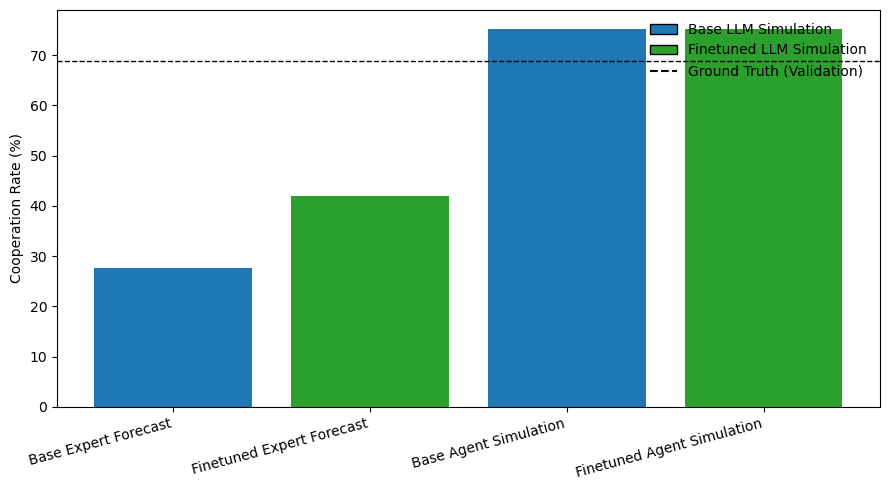

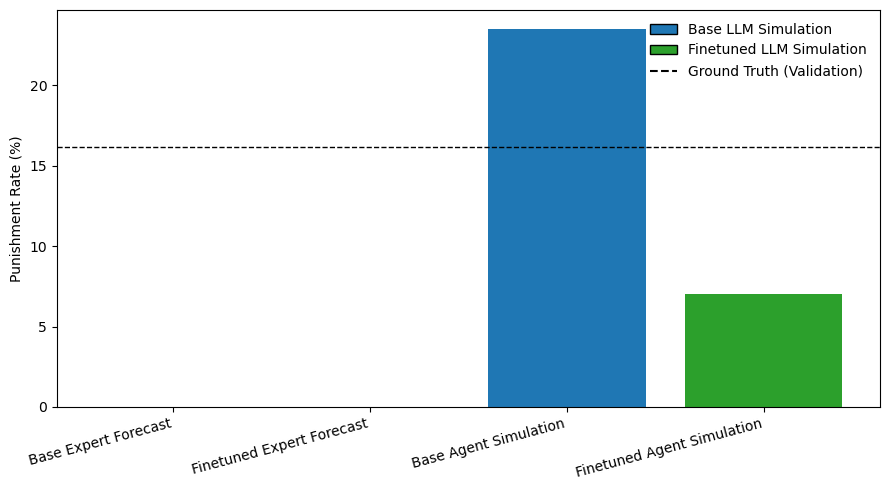

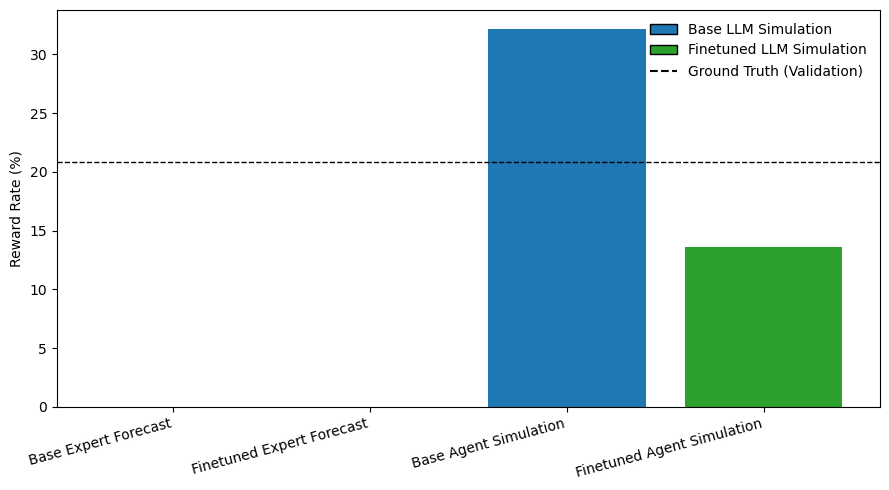

In [19]:
# ==========================================================
# Compare rates: 4 simulation models vs Ground Truth (validation)
# Panels: Cooperation%, Punishment%, Reward%
# Order: Base Expert, Finetuned Expert, Base Agent, Finetuned Agent
# Colors: Base = blue, Finetuned = green
# Punishment / Reward: binary usage (whether any action occurred)
# ==========================================================
import pandas as pd, numpy as np, ast, matplotlib.pyplot as plt

# ----- Paths -----
PATH_SIMS = [
    ("base-obs", "output/llama31-8b-instruct-base-obs_2510142212.csv"),
    ("base-ptc", "output/llama31-8b-instruct-base-ptc_2510150020.csv"),
    ("lora-ptc", "output/llama31-8b-instruct-lora-ptc_2510142305.csv"),
    ("lora-obs", "output/llama31-8b-instruct-lora-obs_2510150133.csv"),
]

df_val = pd.read_csv("data/processed_data/df_analysis_val.csv")
df_gt  = pd.read_csv("data/raw_data/validation_wave/player-rounds.csv")

# ----- Helper -----
def parse_dict_cell(x):
    if isinstance(x, dict): return x
    if isinstance(x, str) and x.strip():
        try:
            return ast.literal_eval(x)
        except Exception:
            return {}
    return {}

# -------------------------------
# Ground truth per-game (binary)
# -------------------------------
cfg_gt = df_val[["gameId","CONFIG_endowment","CONFIG_punishmentExists","CONFIG_rewardExists"]].drop_duplicates()
gt = df_gt.merge(cfg_gt, on="gameId", how="inner")

print(f"[GT] merged player-rounds: {len(gt)} rows, {gt['gameId'].nunique()} unique games")

gt_rows = []
for gid, g in gt.groupby("gameId"):
    E = g["CONFIG_endowment"].iloc[0]
    n_players = g["playerId"].nunique()
    n_rounds  = g["roundId"].nunique()
    n_obs = len(g)

    # cooperation
    contrib_rate = g["data.contribution"].fillna(0).sum() / (n_players * E * n_rounds) if (n_players and n_rounds and E) else np.nan

    # binary punishment / reward
    g["punish_flag"] = g["data.punished"].fillna("{}").astype(str).apply(lambda s: 1 if parse_dict_cell(s) else 0)
    g["reward_flag"] = g["data.rewarded"].fillna("{}").astype(str).apply(lambda s: 1 if parse_dict_cell(s) else 0)

    punish_rate = g["punish_flag"].mean()
    reward_rate = g["reward_flag"].mean()

    # include denominator only where mechanism exists
    if not bool(g["CONFIG_punishmentExists"].iloc[0]): punish_rate = np.nan
    if not bool(g["CONFIG_rewardExists"].iloc[0]):    reward_rate = np.nan

    gt_rows.append({
        "gameId": gid,
        "contrib_rate": contrib_rate,
        "punish_rate": punish_rate,
        "reward_rate": reward_rate
    })

gt_per_game = pd.DataFrame(gt_rows)
GT_CONTRIB = gt_per_game["contrib_rate"].mean()
GT_PUNISH  = gt_per_game["punish_rate"].mean(skipna=True)
GT_REWARD  = gt_per_game["reward_rate"].mean(skipna=True)
print(f"[GT means] coop={GT_CONTRIB:.3f}, punish={GT_PUNISH:.3f}, reward={GT_REWARD:.3f}")

# -------------------------------
# Simulation per-game (binary)
# -------------------------------
cfg_sim = df_val[["name","CONFIG_endowment","CONFIG_punishmentExists","CONFIG_rewardExists"]].drop_duplicates()
cfg_sim_idx = cfg_sim.set_index("name")

def sim_rates_binary(sim_path: str) -> pd.DataFrame:
    sim = pd.read_csv(sim_path)
    rows = []
    for gid_name, g in sim.groupby("gameId"):
        if gid_name not in cfg_sim_idx.index:
            continue
        E   = cfg_sim_idx.loc[gid_name, "CONFIG_endowment"]
        n_p = g["playerAvatar"].nunique()
        n_r = g["roundIndex"].nunique()

        contrib_rate = g["data.contribution"].fillna(0).sum() / (n_p * E * n_r) if (n_p and n_r and E) else np.nan

        g["punish_flag"] = g.get("data.punished", pd.Series(index=g.index, dtype=object)).fillna("{}").astype(str).apply(lambda s: 1 if parse_dict_cell(s) else 0)
        g["reward_flag"] = g.get("data.rewarded", pd.Series(index=g.index, dtype=object)).fillna("{}").astype(str).apply(lambda s: 1 if parse_dict_cell(s) else 0)

        punish_rate = g["punish_flag"].mean()
        reward_rate = g["reward_flag"].mean()

        pun_exists = bool(cfg_sim_idx.loc[gid_name, "CONFIG_punishmentExists"])
        rew_exists = bool(cfg_sim_idx.loc[gid_name, "CONFIG_rewardExists"])
        if not pun_exists: punish_rate = np.nan
        if not rew_exists: reward_rate = np.nan

        rows.append({
            "gameId_name": gid_name,
            "contrib_rate": contrib_rate,
            "punish_rate":  punish_rate,
            "reward_rate":  reward_rate
        })
    return pd.DataFrame(rows)

sim_tables = {k: sim_rates_binary(p) for k, p in PATH_SIMS}

sim_means = {
    k: {
        "contrib": float(v["contrib_rate"].mean()) if not v.empty else np.nan,
        "punish":  float(v["punish_rate"].mean(skipna=True)) if not v.empty else np.nan,
        "reward":  float(v["reward_rate"].mean(skipna=True)) if not v.empty else np.nan,
    }
    for k, v in sim_tables.items()
}

# -------------------------------
# Plot panels (percent; fixed order/colors)
# -------------------------------
order_keys   = ["base-obs","lora-obs","base-ptc","lora-ptc"]
order_labels = ["Base Expert Forecast","Finetuned Expert Forecast",
                "Base Agent Simulation","Finetuned Agent Simulation"]
order_colors = ["#1f77b4","#2ca02c","#1f77b4","#2ca02c"]

def panel_bar_with_gt(metric_key: str, gt_value: float, ylabel: str):
    vals = [sim_means.get(k, {}).get(metric_key, np.nan) for k in order_keys]
    x = np.arange(len(order_keys))
    plt.figure(figsize=(9,5))
    plt.bar(x, np.array(vals)*100.0, color=order_colors, tick_label=order_labels)
    plt.xticks(rotation=15, ha="right")
    plt.ylabel(f"{ylabel} (%)")

    from matplotlib.patches import Patch
    plt.axhline(gt_value*100.0, linestyle="--", color="k", linewidth=1)
    legend_handles = [
        Patch(facecolor="#1f77b4", edgecolor="black", label="Base LLM Simulation"),
        Patch(facecolor="#2ca02c", edgecolor="black", label="Finetuned LLM Simulation"),
        plt.Line2D([0],[0], color="k", linestyle="--", label="Ground Truth (Validation)"),
    ]
    plt.legend(handles=legend_handles, loc="upper right", frameon=False)

    plt.tight_layout()
    plt.show()

panel_bar_with_gt("contrib", GT_CONTRIB, "Cooperation Rate")
panel_bar_with_gt("punish",  GT_PUNISH,  "Punishment Rate")
panel_bar_with_gt("reward",  GT_REWARD,  "Reward Rate")